<a href="https://colab.research.google.com/github/joe-granick/CS439/blob/main/data_ingest10K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libries

In [115]:
!pip install sec_edgar_downloader

In [117]:
import os
import glob
import re
import json
import pprint
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from sec_edgar_downloader import Downloader
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation



# configure downloader

In [172]:
USER  = "Joe Granick (jmgranick@gmail.com)"
EMAIL = "jmgranick@gmail.com"
DOWNLOAD_DIRDIR = "/mnt/data/10k_filings"
TICKERS = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "ORCL", "CSCO",
    "JPM", "V", "BAC", "BRK-B",
    "JNJ", "UNH", "PFE",
    "WMT", "KO", "PG", "DIS", "NKE",
    "XOM", "CVX", "BA", "CAT"
]

FILING_YEARS = 20
FILING_TYPE = "10-K"


dl = Downloader(USER, EMAIL, DIR)
for ticker in TICKERS:
  dl.get(FILING_TYPE, ticker,limit=FILING_YEARS, download_details=True)

# Read in Text Corpus From Folder

In [173]:
DOWNLOAD_DIR = "/mnt/data/10k_filings"
pattern = os.path.join(DOWNLOAD_DIR, "sec-edgar-filings", "*", "10-K", "*", "primary-document.html")
paths = glob.glob(pattern)

docs = {}
for path in paths:
    raw = open(path, "r", encoding="utf-8").read()
    soup = BeautifulSoup(raw, "html.parser")
    for tag in soup(["script","style"]):
        tag.decompose()
    text = soup.get_text(" ")
    text = re.sub(r"\s+", " ", text).strip()

    # parse ticker/year
    parts  = path.split(os.sep)
    ticker = parts[-4]
    mdate  = re.search(r"FILED AS OF DATE:\s*(\d{8})", raw)
    year   = mdate.group(1)[:4] if mdate else parts[-2].split("-")[1]
    docs[f"{ticker}_{year}"] = text



# Clean Text

In [186]:
stop = set(ENGLISH_STOP_WORDS)
extra_noise = {"company","item","year","form","related","certain","total","based",
         "gaap","services","financial","products","income","business",
          "tax","net","including","billion","stock","notes","securities",
          "revenue","value","operating","statements","cloud","cash",
          "assets","new","information","customers",
          "fair","results","revenues","december","data", "use","period","years",
         "contents", "report", "table", "content","non","class",
         "virtue","password","consummated","acts","necessarily", "regardless",
         "customized","indirect","south","believes", "index","term","freq",
          "term","share","sales","rate","primarily","plan", "operations","note","million",
          "market","management","losses","loss","loans","liabilities","future",
          "fiscal","firm","expense","equity","debt","credit","costs","cost","corporation", "consolidated","common","changes","capital"}

more_noise = {
    "foreign","ended","included","increase","current","product","millions",
    "balance","result","rates","shares","long","activities","include",
    "increased","reporting","currency","commercial","amounts","subject",
    "contracts","plans"
}
month_words    = {"january","february","march","april","may","june",
                  "july","august","september","october","november","december"}
number_terms   = {"percent","approximately","average","basis","additional","annual",
                  "times","respectively"}
geo_stop       = {"united","states","incorporated","consumer"}  # generic proper nouns
verb_nouns     = {"included","used","following","recorded","result","plan","plans"}
auto_noise = {
    "larger","participate","permitted","usage","media","enterprise","llc",
    "hedge","africa","applying","collectively","groups","points",
    "enforcement","orders","subsequently","inputs","repurchased",
    "enacted","investigations"
}
new_noise = month_words | number_terms | geo_stop | verb_nouns| more_noise | auto_noise
extra_noise |= new_noise

stop |= extra_noise
def tokenize(text):
    tokens = re.findall(r"\b[a-zA-Z]{3,}\b", text.lower())
    return [t for t in tokens if t not in stop]

cleaned_texts = {k: " ".join(tokenize(v)) for k,v in docs.items()}

# EDA

## Word Count

term   freq
0          risk  55862
1    accounting  33408
2      earnings  32772
3   significant  32282
4        impact  32145
..          ...    ...
95        lease  15489
96       effect  15321
97          bac  15310
98      support  15247
99  acquisition  15222

[100 rows x 2 columns]

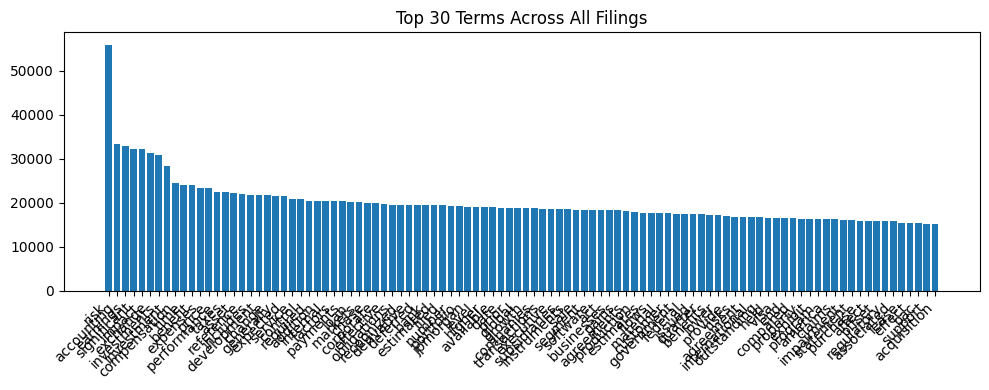

In [187]:
# Term Frequency
all_tokens = [tok for doc in cleaned_texts.values() for tok in doc.split()]
freq = Counter(all_tokens)
df_freq = pd.DataFrame(freq.most_common(100), columns=["term","freq"])
display(df_freq)

# plot
plt.figure(figsize=(10,4))
plt.bar(df_freq["term"], df_freq["freq"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 100 Terms Across All Filings")
plt.tight_layout()
plt.show()

## TF-IDF

In [188]:
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[a-zA-Z]{3,}\b')
X = vectorizer.fit_transform(cleaned_texts.values())
feat = vectorizer.get_feature_names_out()

rows = []
for i,(key,_) in enumerate(cleaned_texts.items()):
    row = X[i].toarray().flatten()
    for idx in row.argsort()[::-1][:5]:
        rows.append({"document": key, "term": feat[idx], "score": row[idx]})
df_tfidf = pd.DataFrame(rows)
display(df_tfidf)

document               term     score
0      PFE_15             pfizer  0.433415
1      PFE_15  biopharmaceutical  0.241080
2      PFE_15          medicines  0.190308
3      PFE_15     pharmaceutical  0.168932
4      PFE_15            generic  0.161648
...       ...                ...       ...
2225  CSCO_22               csco  0.675168
2226  CSCO_22              cisco  0.247817
2227  CSCO_22             viasat  0.112198
2228  CSCO_22            service  0.108909
2229  CSCO_22           software  0.091376

[2230 rows x 3 columns]

## Bigram

In [166]:
bigrams = Counter()
for text in cleaned_texts.values():
    toks = text.split()
    bigrams.update(zip(toks, toks[1:]))

# top 20 bigrams
df_bi = pd.DataFrame(bigrams.most_common(20), columns=["bigram","count"])
print(df_bi)

                                               bigram  count
0                                   (jpmorgan, chase)  10141
1                                        (long, term)   4134
2                                    (united, states)   3713
3                                  (million, million)   3407
4                                     (gains, losses)   3060
5                                 (internal, control)   2872
6                             (consolidated, balance)   2514
7                                (control, reporting)   2413
8                                  (risk, management)   2397
9                                   (balance, sheets)   2327
10                                   (credit, losses)   2232
11                                     (credit, card)   2125
12                          (incorporated, reference)   2091
13  (jpm, consumerexcludingcreditcardloanportfolio...   1996
14                                (weighted, average)   1988
15                      

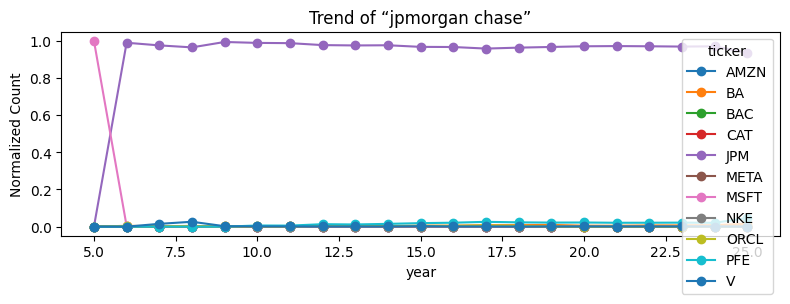

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


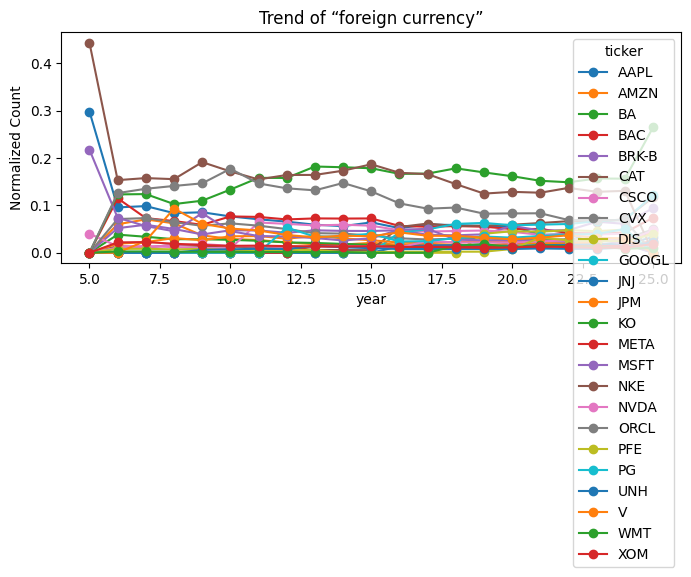

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


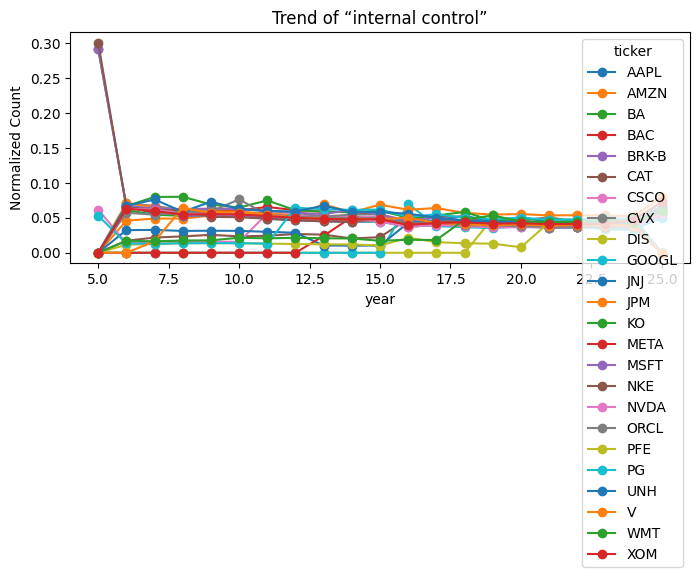

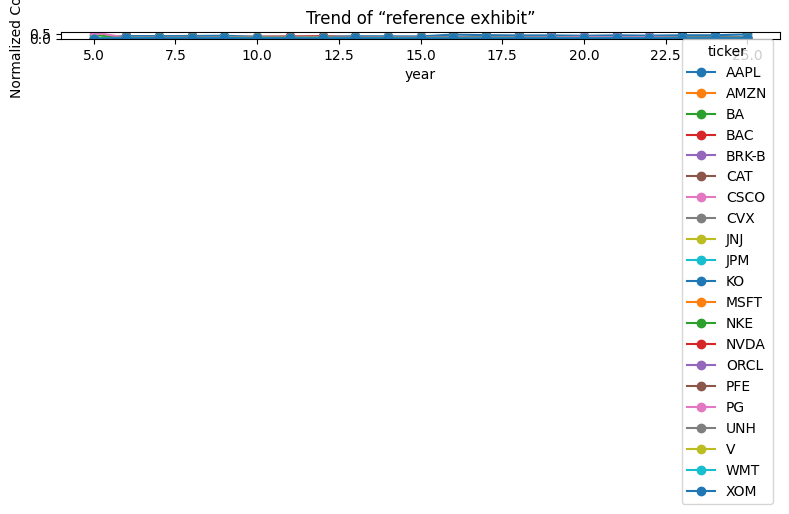

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


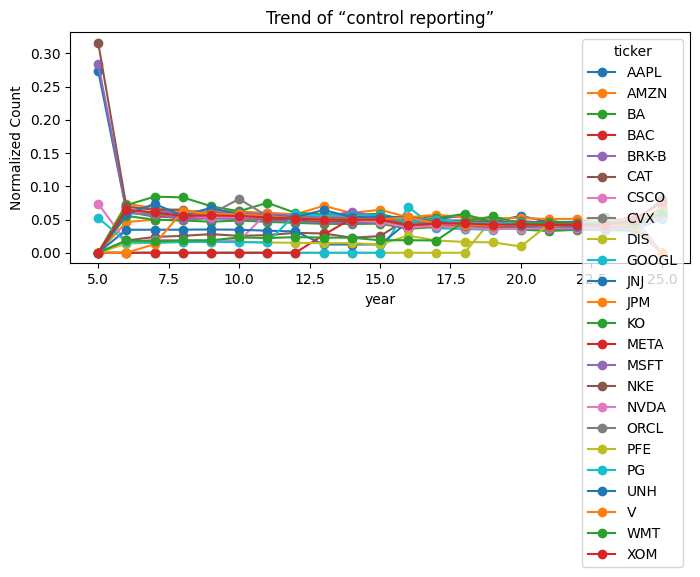

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


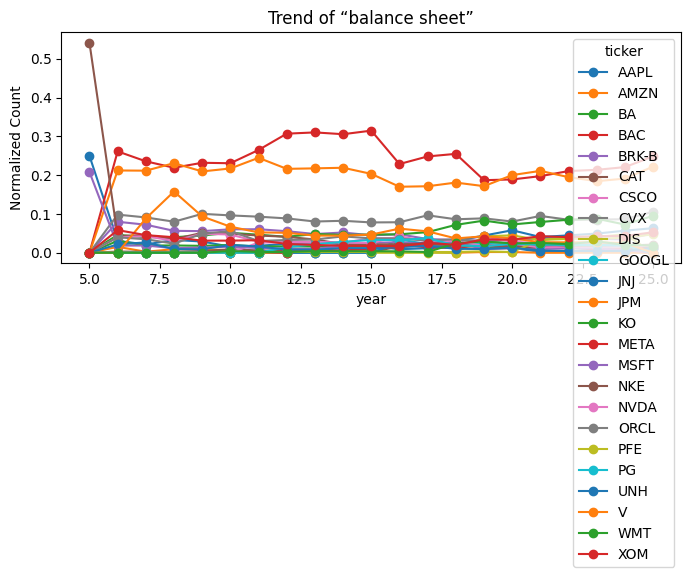

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


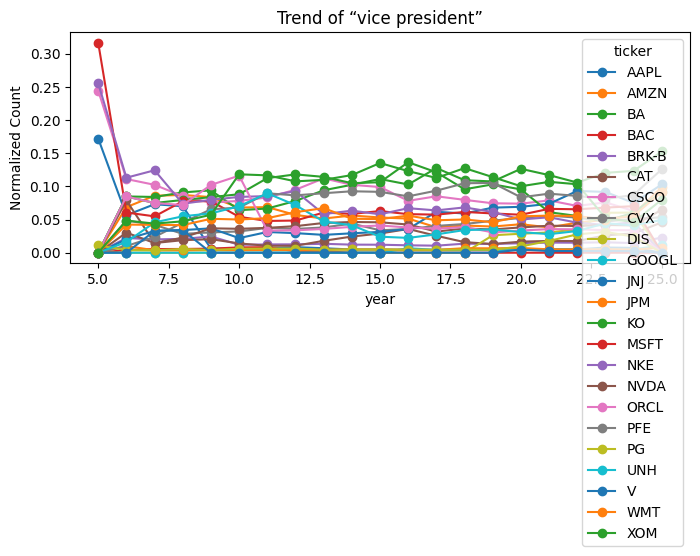

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


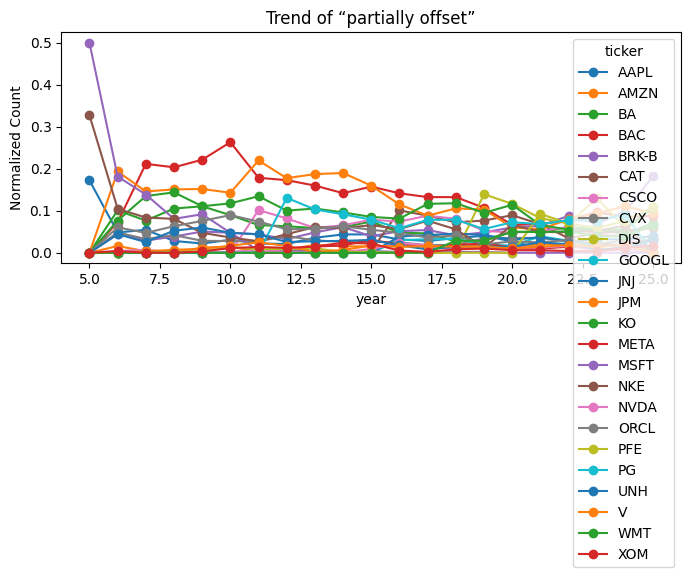

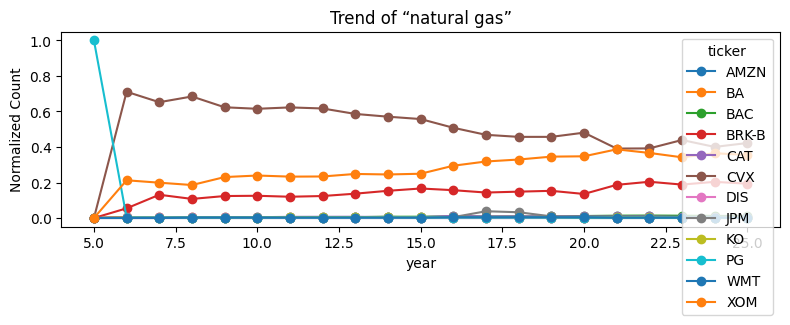

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


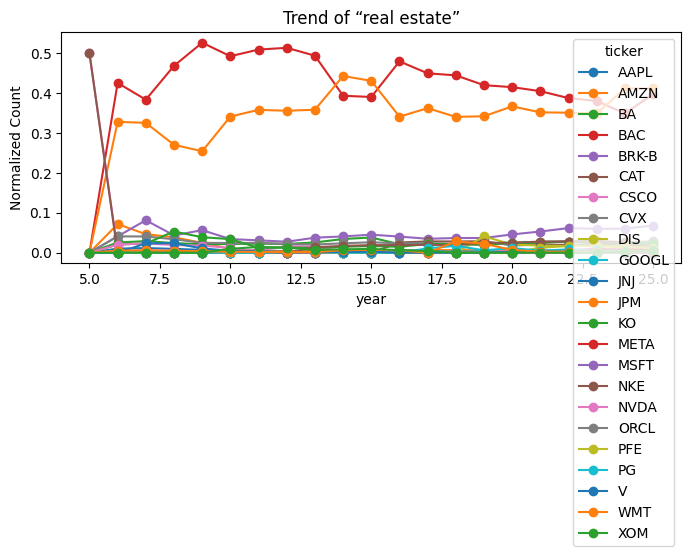

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


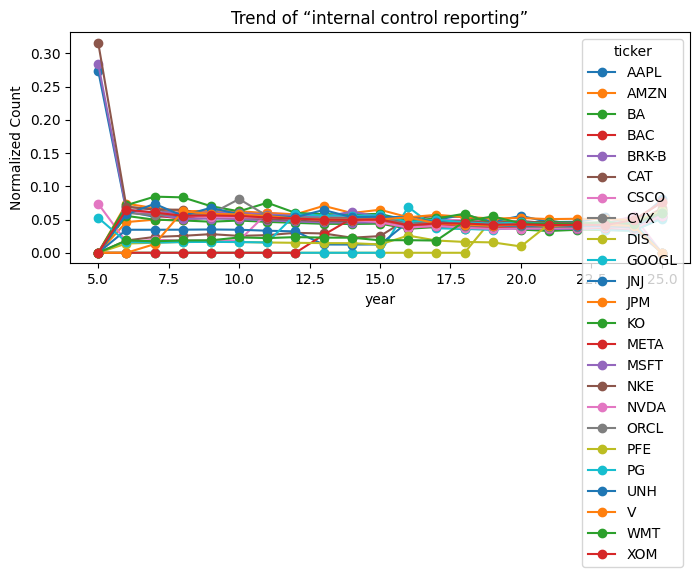

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


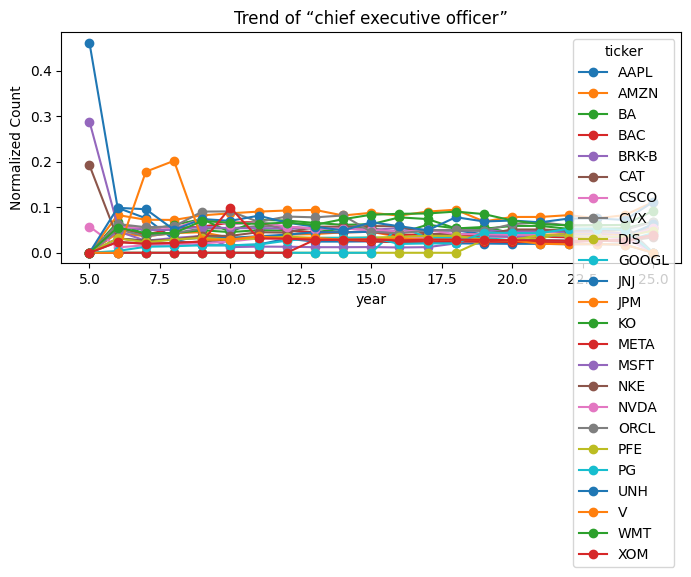

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


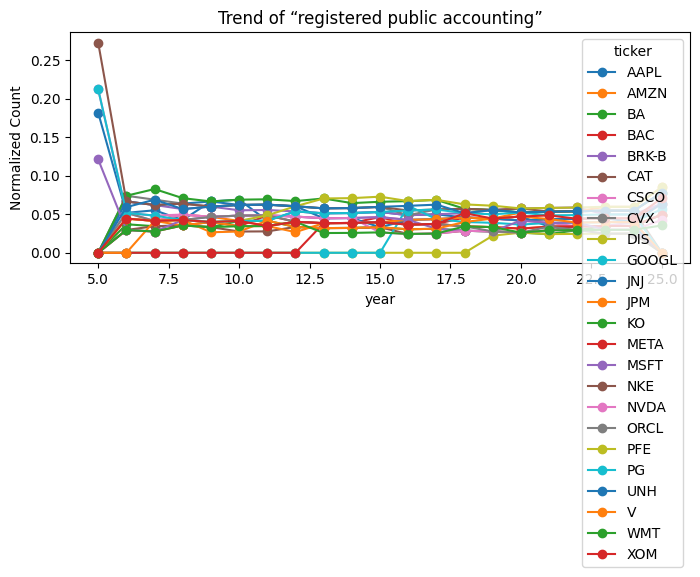

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


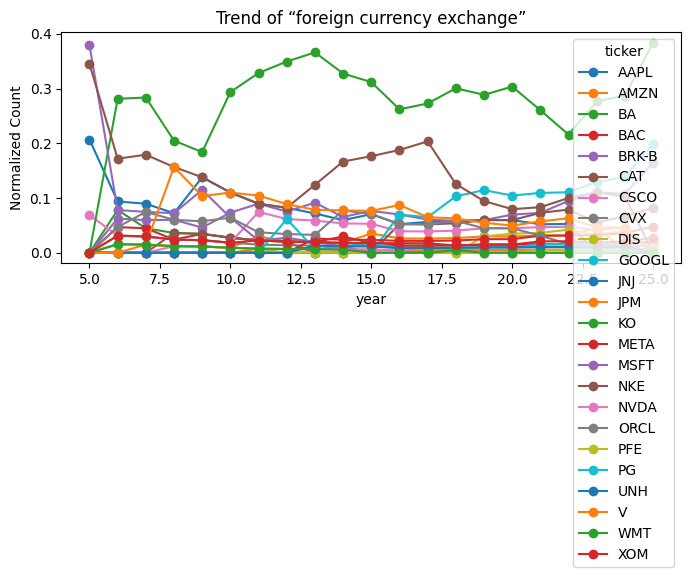

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


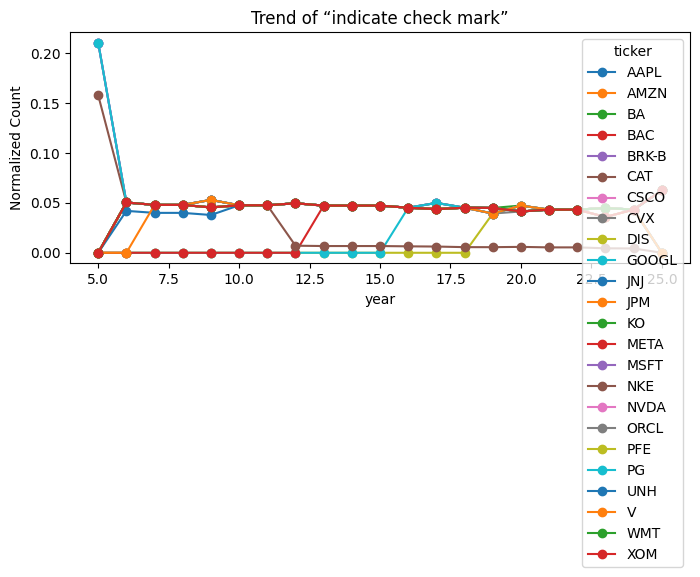

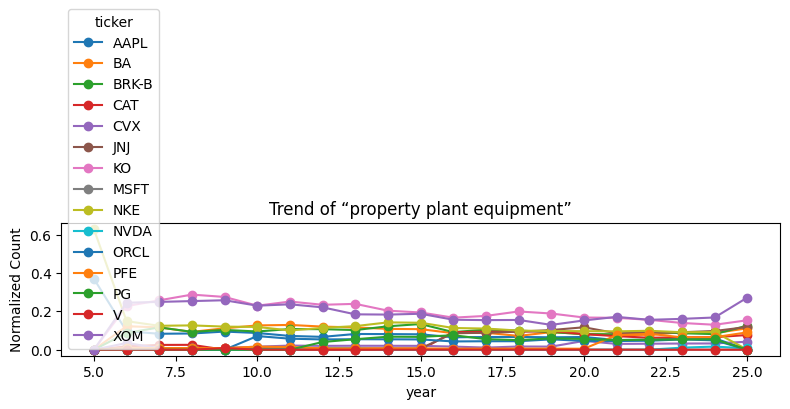

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


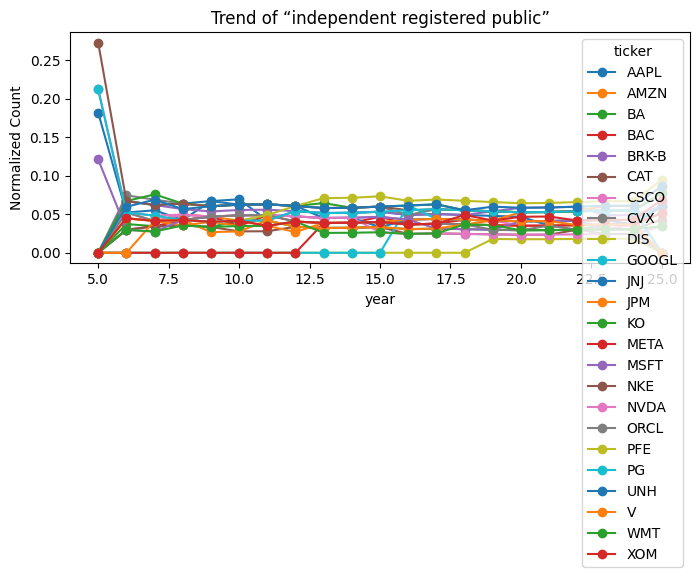

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


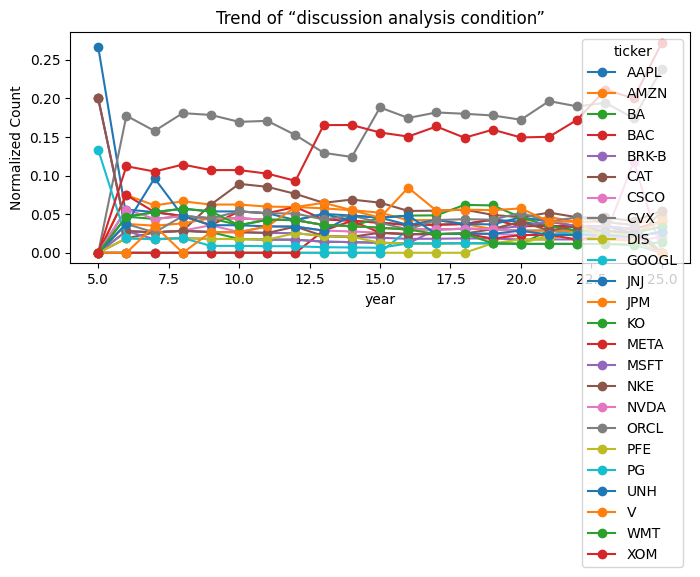

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


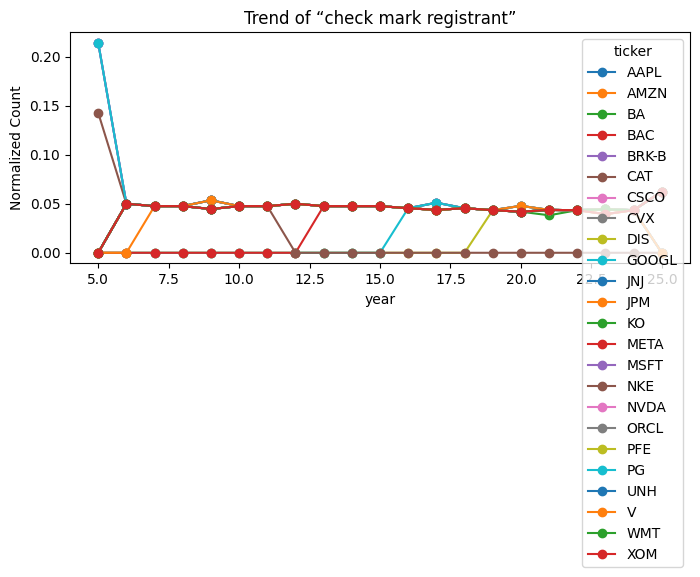

<ipython-input-190-6bc4168eb8cf>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


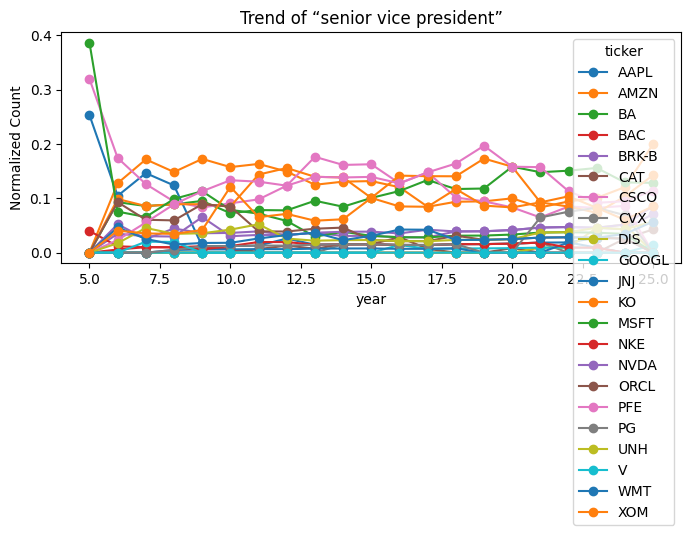

In [190]:
# document bigram & trigram counts
rows = []
for key, text in cleaned_pruned.items():
    ticker, year = key.split("_")
    toks = text.split()
    # bigrams
    bi = Counter(zip(toks, toks[1:]))
    # trigrams
    tri = Counter(zip(toks, toks[1:], toks[2:]))
    for phrase, cnt in bi.items():
        rows.append({"ticker":ticker,"year":int(year),"gram":" ".join(phrase),"count":cnt})
    for phrase, cnt in tri.items():
        rows.append({"ticker":ticker,"year":int(year),"gram":" ".join(phrase),"count":cnt})

df_grams = pd.DataFrame(rows)

#top N phrases
top_bi = (df_grams[df_grams.gram.str.count(" ")==1]
          .groupby("gram")["count"]
          .sum()
          .nlargest(10)
          .index.tolist())
top_tri = (df_grams[df_grams.gram.str.count(" ")==2]
           .groupby("gram")["count"]
           .sum()
           .nlargest(10)
           .index.tolist())

# trends
for gram in top_bi + top_tri:
    sub = df_grams[df_grams.gram == gram].pivot(
        index="year",
        columns="ticker",
        values="count"
    ).fillna(0)
    sub_norm = sub.div(sub.sum(axis=1), axis=0)
    sub_norm.plot(figsize=(8,3), marker="o", title=f"Trend of “{gram}”")
    plt.ylabel("Normalized Count")
    plt.tight_layout()
    plt.show()



## Topic Modeling w/ LDA

In [195]:
cv = CountVectorizer(token_pattern=r'(?u)\b[a-zA-Z]{3,}\b', stop_words=list(stop), max_df=.9)
X = cv.fit_transform(cleaned_texts.values())

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

terms = cv.get_feature_names_out()
for i, comp in enumerate(lda.components_):
    top_terms = [terms[j] for j in comp.argsort()[-10:]]
    print(f"Topic {i+1}: {', '.join(top_terms)}")


Topic 1: production, manufacturing, shareholders, brand, pfizer, care, nvidia, aircraft, pfe, nike
Topic 2: caterpillar, exxonmobil, crude, proved, chevron, cat, reserves, production, gas, oil
Topic 3: court, coca, cola, license, intangible, bottling, hardware, oracle, jnj, software
Topic 4: network, medicare, dis, unitedhealth, medical, reinsurance, berkshire, care, brka, visa
Topic 5: banking, trading, allowance, card, jpm, mortgage, bac, jpmorgan, loan, chase


# Time Series Trends

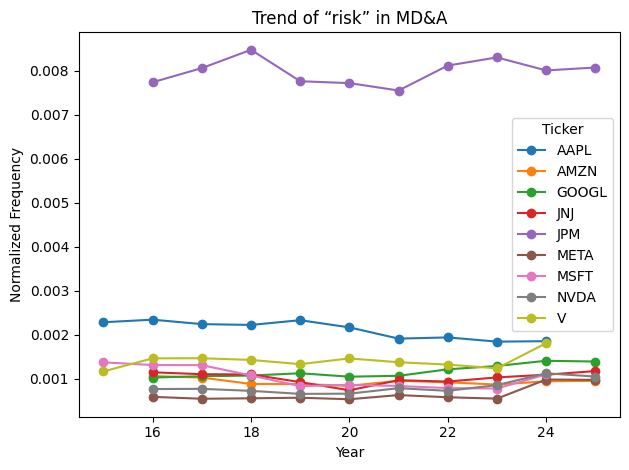

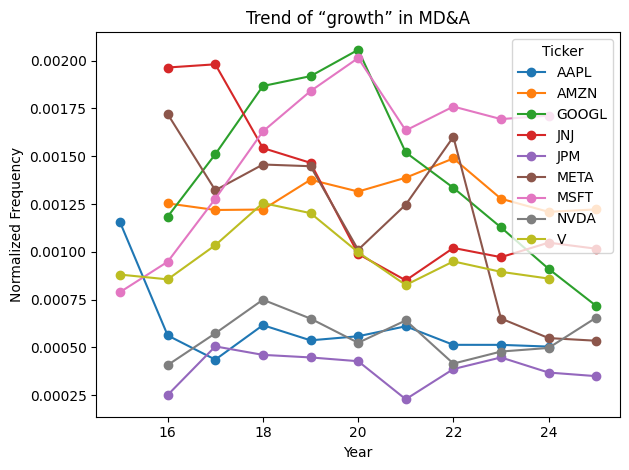

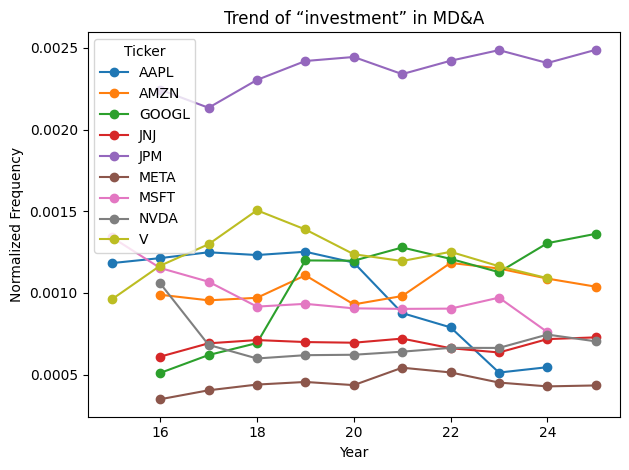

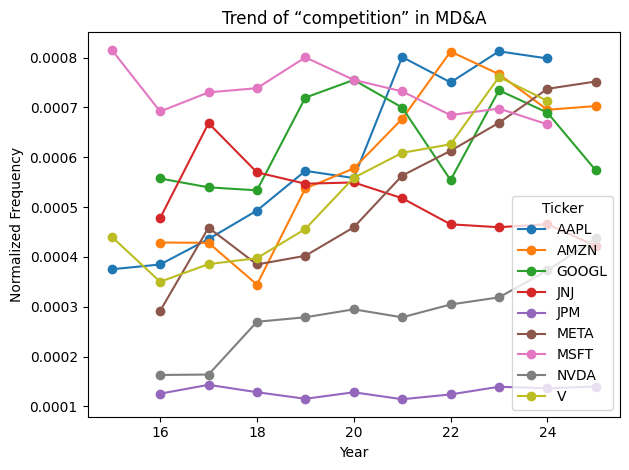

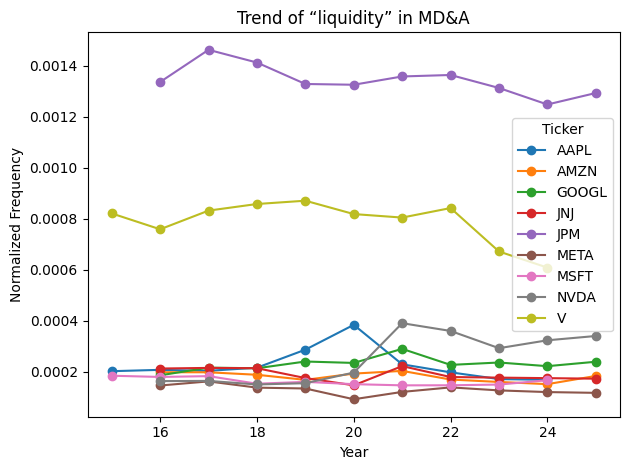

In [170]:
trend_terms = ["risk","growth","investment","competition","liquidity"]

rows = []
for key, text in docs.items():
    ticker, year = key.split("_")
    # simple tokenizer + count
    toks = re.findall(r"\b[a-zA-Z]{3,}\b", text.lower())
    total = len(toks)
    counts = Counter(toks)
    for term in trend_terms:
        rows.append({
            "ticker": ticker,
            "year":   int(year),
            "term":   term,
            "freq":   counts[term] / total
        })
df = pd.DataFrame(rows)

for term in trend_terms:
    df_term = df[df.term == term]
    pivot = df_term.pivot(
        index="year",
        columns="ticker",
        values="freq"
    )
    pivot.plot(marker="o")
    plt.title(f"Trend of “{term}” in MD&A")
    plt.ylabel("Normalized Frequency")
    plt.xlabel("Year")
    plt.legend(title="Ticker")
    plt.tight_layout()
    plt.show()


## sector trends

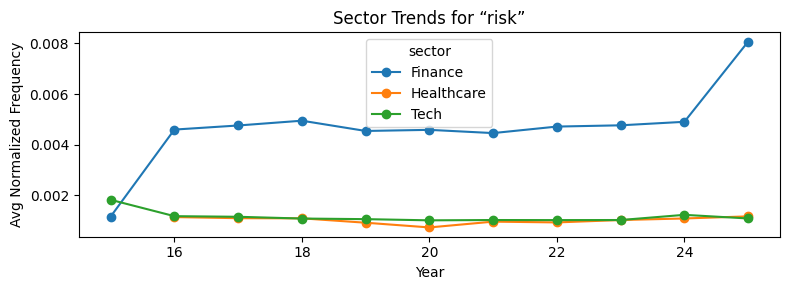

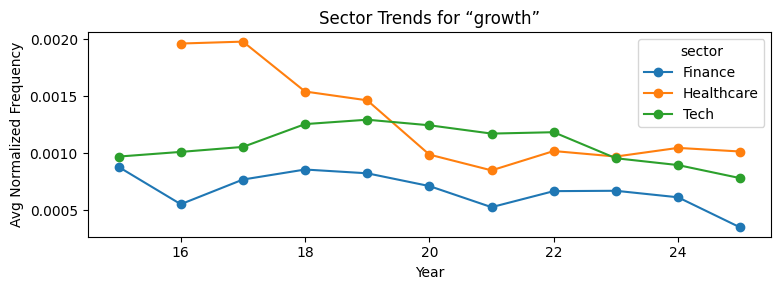

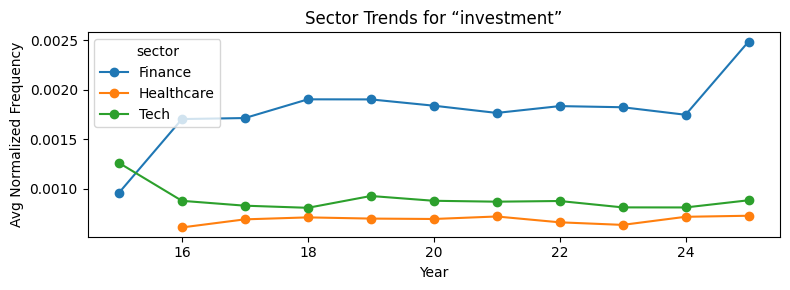

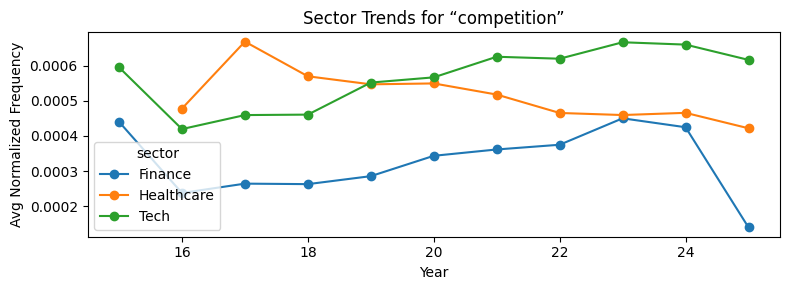

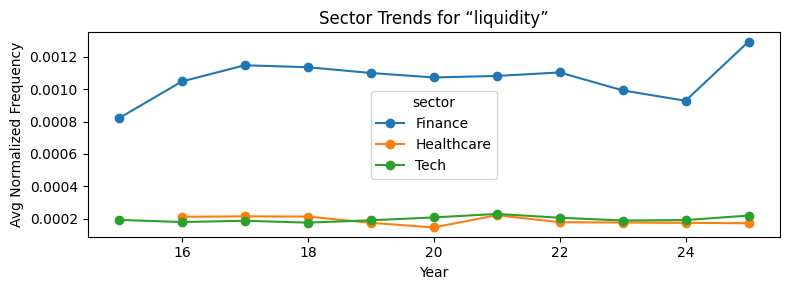

In [193]:
sector_map = {
  **{t:"Tech"     for t in ["AAPL","MSFT","GOOGL","AMZN","NVDA","META","ORCL","CSCO"]},
  **{t:"Finance"  for t in ["JPM","V","BAC","BRK-B","WFC"]},
  **{t:"Healthcare" for t in ["JNJ","UNH","PFE"]},
  **{t:"Consumer" for t in ["WMT","KO","PG","DIS","NKE"]},
  **{t:"Energy"   for t in ["XOM","CVX"]},
  **{t:"Industrial" for t in ["BA","CAT"]}
}

df["sector"] = df.ticker.map(sector_map)
sector_trends = (df
 .groupby(["year","sector","term"])["freq"]
 .mean()
 .reset_index())


for term in trend_terms:
    df_term = sector_trends[sector_trends.term == term]
    pivot = df_term.pivot(
        index="year",
        columns="sector",
        values="freq"
    )
    pivot.plot(figsize=(8,3), marker="o")
    plt.title(f"Sector Trends for “{term}”")
    plt.ylabel("Avg Normalized Frequency")
    plt.xlabel("Year")
    plt.tight_layout()
    plt.show()

<Figure size 800x300 with 0 Axes>

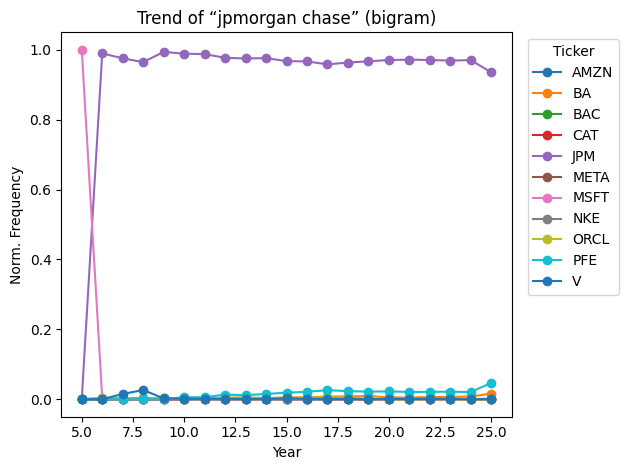

<Figure size 800x300 with 0 Axes>

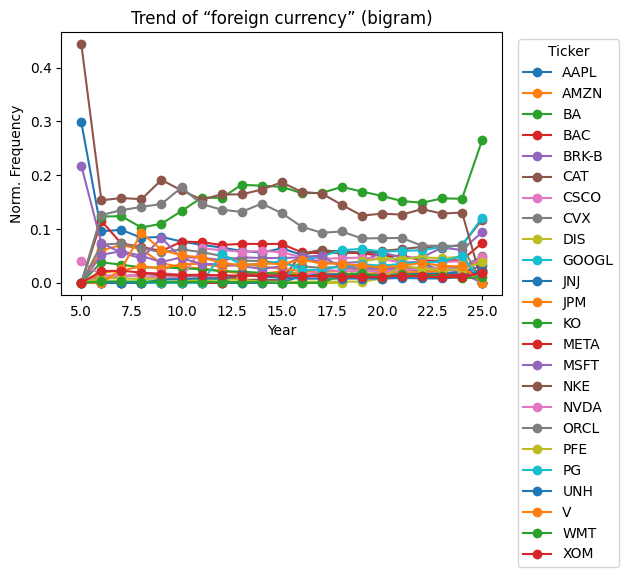

<Figure size 800x300 with 0 Axes>

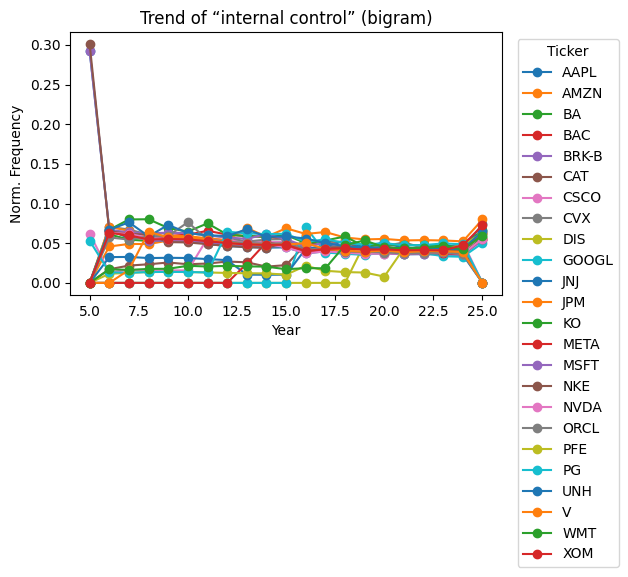

<Figure size 800x300 with 0 Axes>

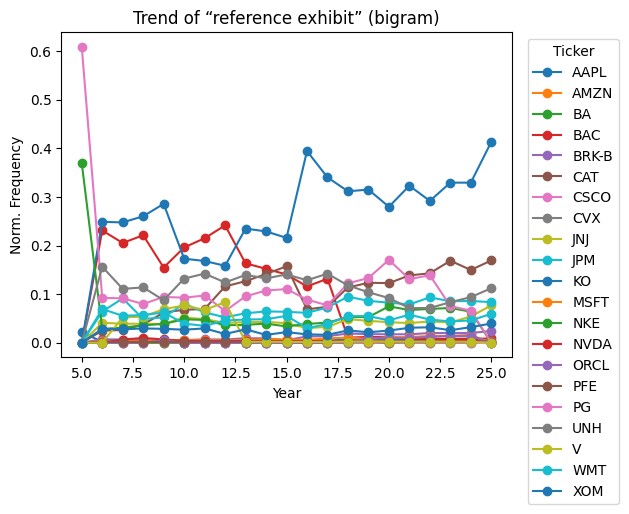

<Figure size 800x300 with 0 Axes>

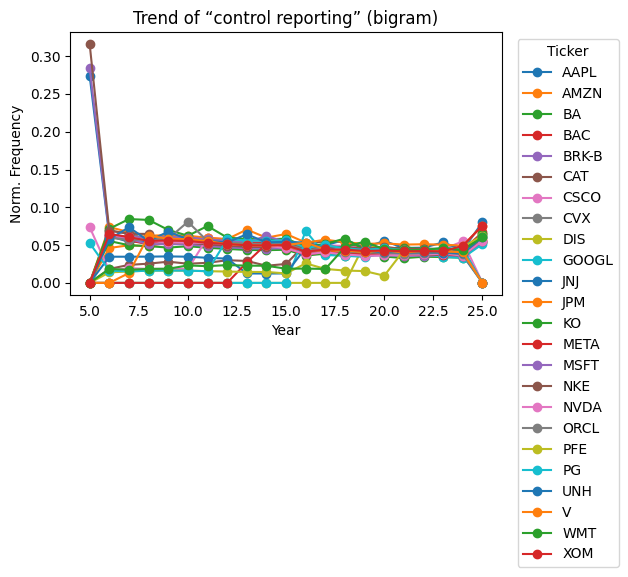

<Figure size 800x300 with 0 Axes>

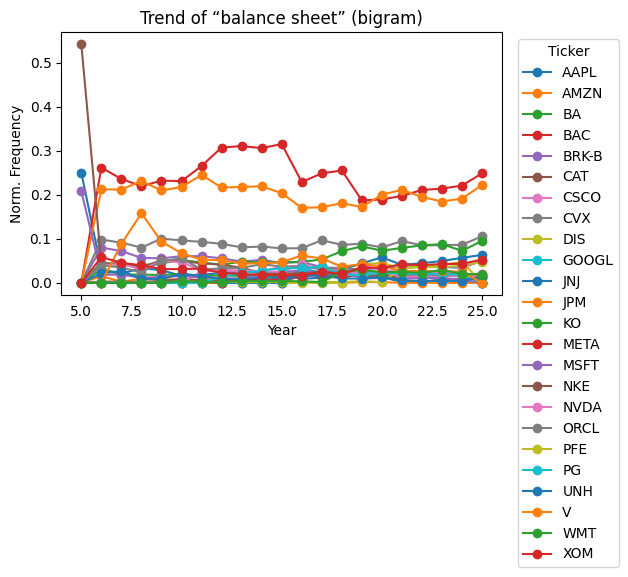

<Figure size 800x300 with 0 Axes>

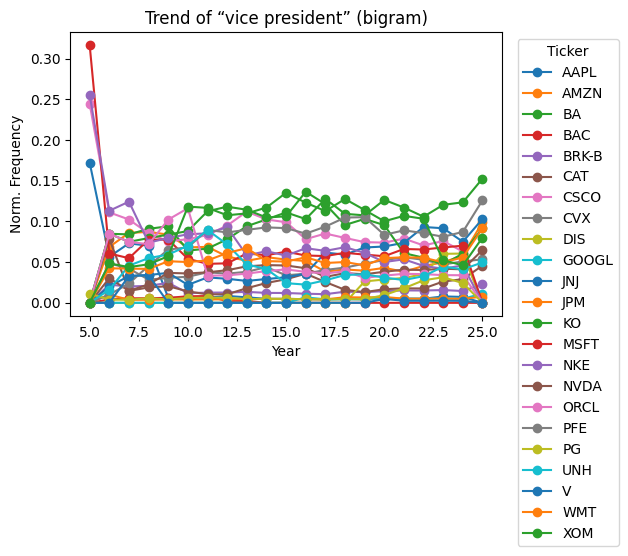

<Figure size 800x300 with 0 Axes>

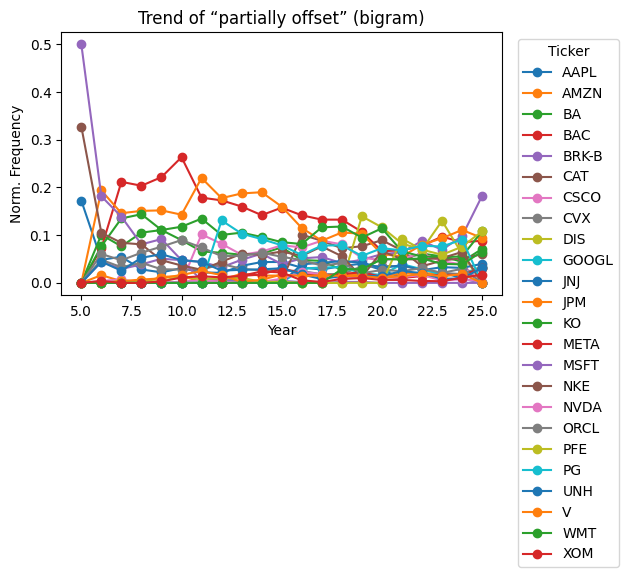

<Figure size 800x300 with 0 Axes>

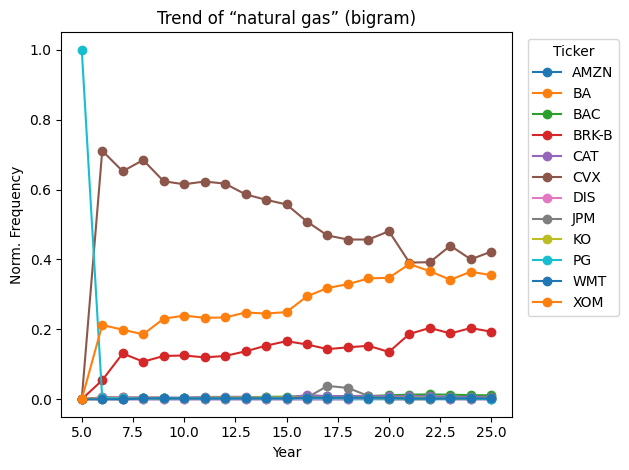

<Figure size 800x300 with 0 Axes>

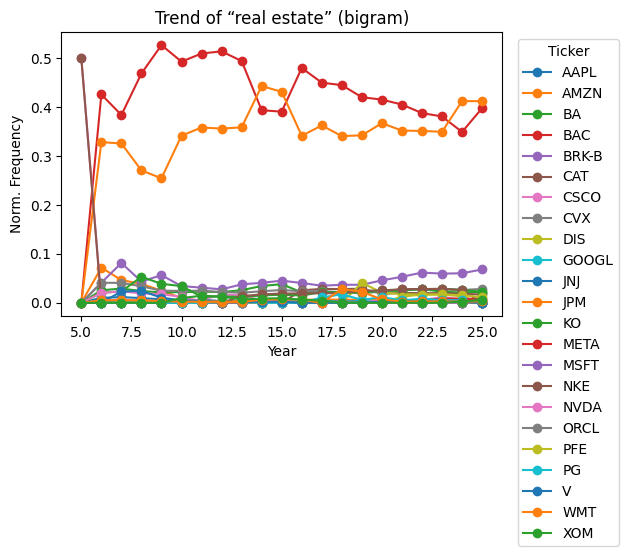

<Figure size 800x300 with 0 Axes>

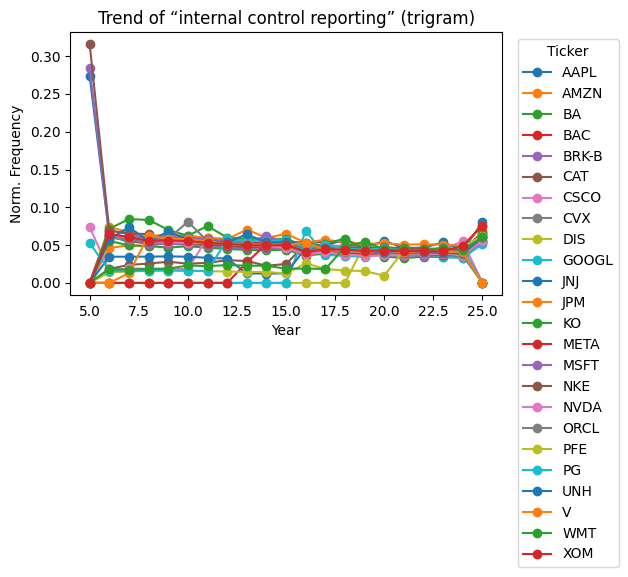

<Figure size 800x300 with 0 Axes>

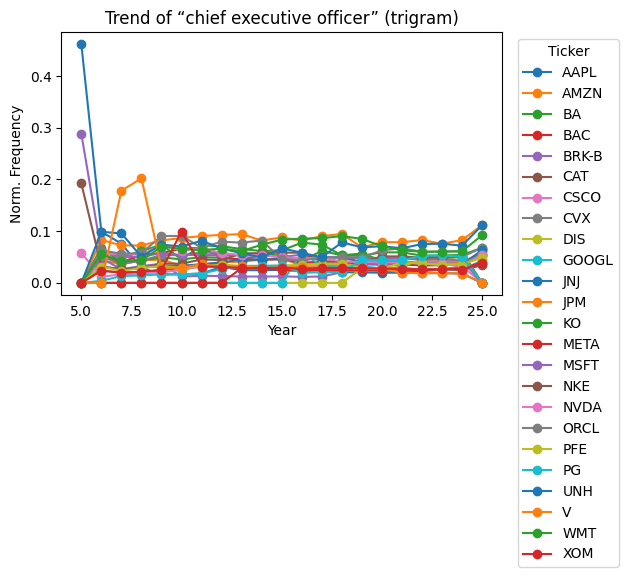

<Figure size 800x300 with 0 Axes>

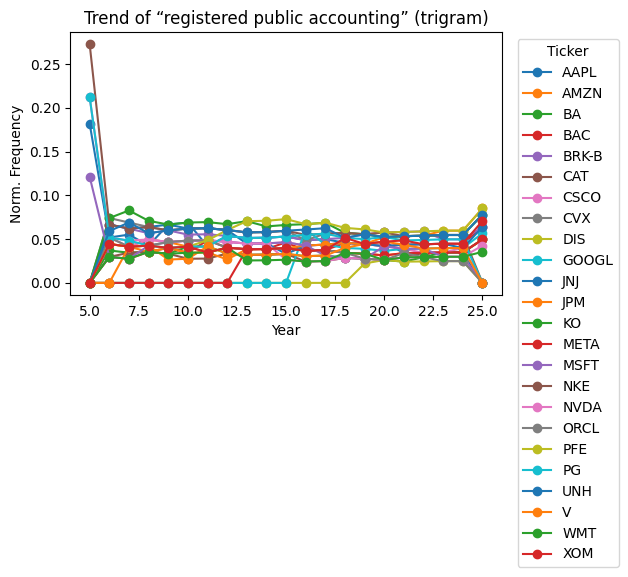

<Figure size 800x300 with 0 Axes>

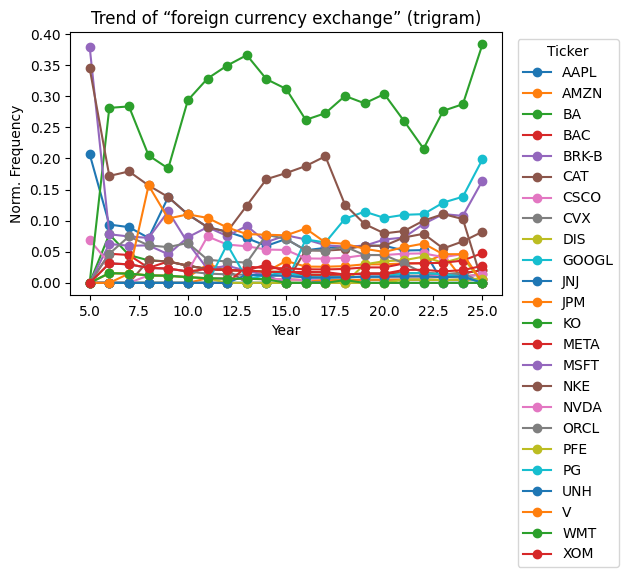

<Figure size 800x300 with 0 Axes>

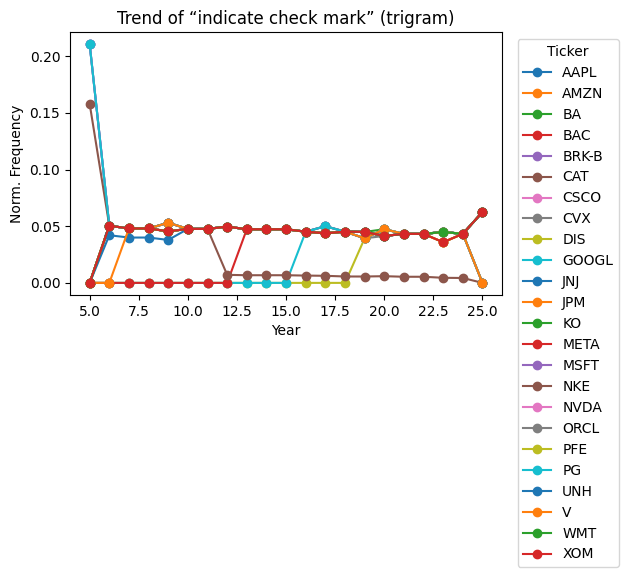

<Figure size 800x300 with 0 Axes>

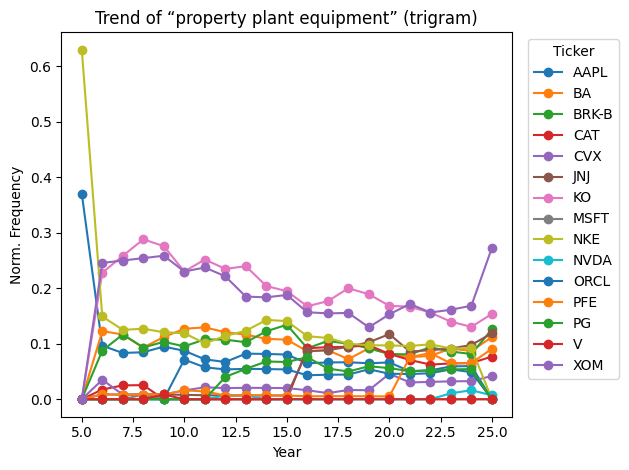

<Figure size 800x300 with 0 Axes>

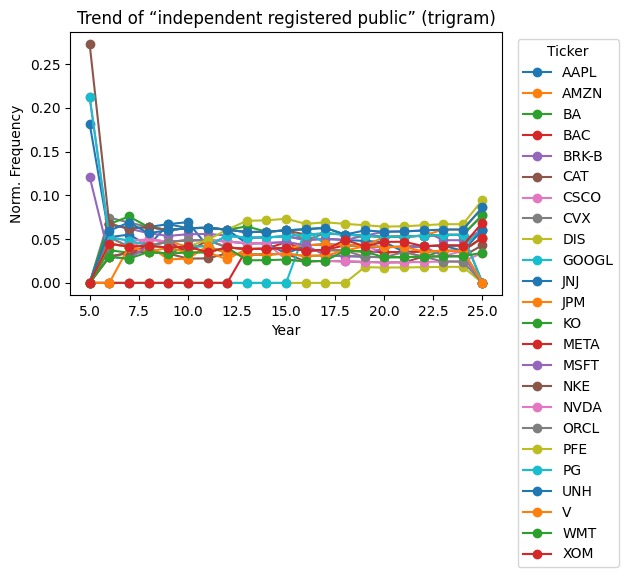

<Figure size 800x300 with 0 Axes>

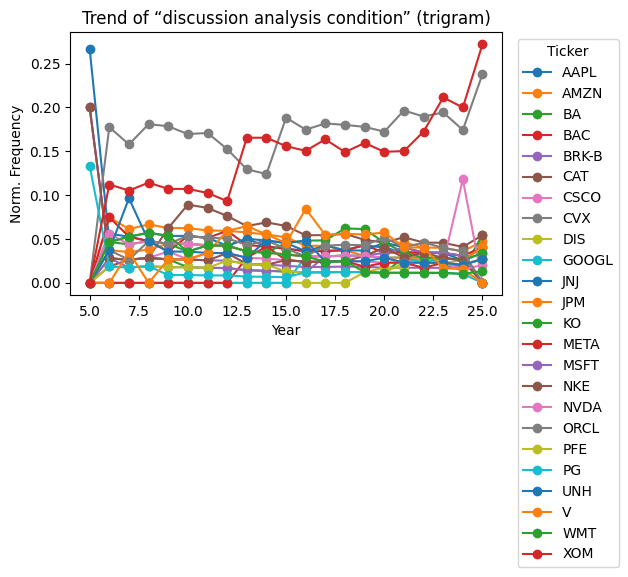

<Figure size 800x300 with 0 Axes>

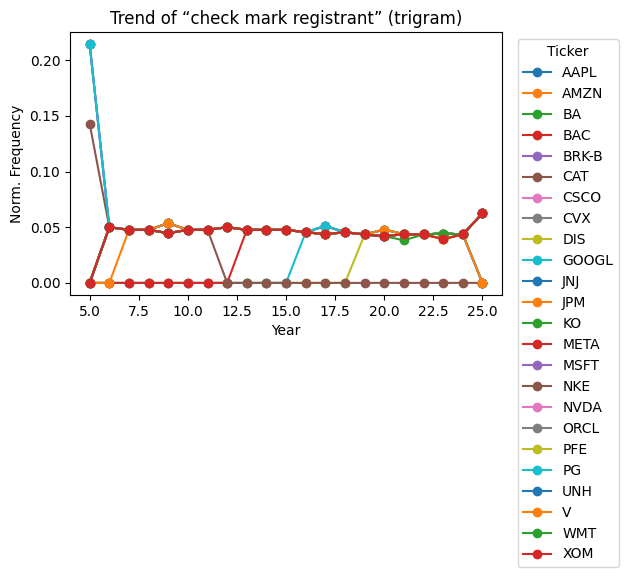

<Figure size 800x300 with 0 Axes>

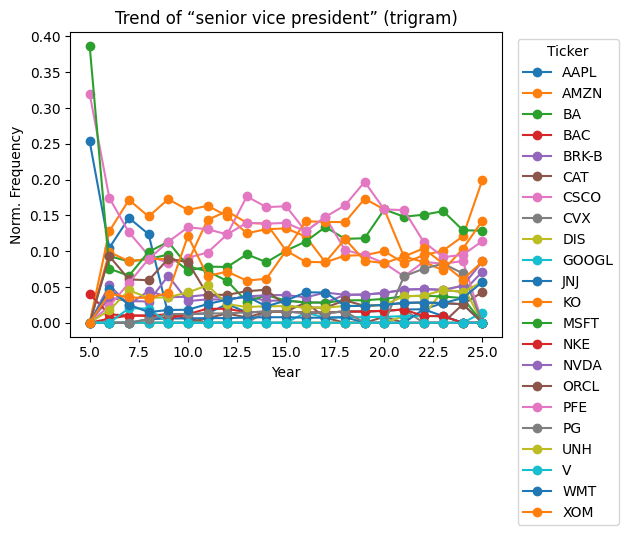

In [194]:
rows = []
for key, text in cleaned_pruned.items():
    ticker, year = key.split("_")
    toks = text.split()
    bi  = Counter(zip(toks, toks[1:]))
    tri = Counter(zip(toks, toks[1:], toks[2:]))
    for gram, cnt in bi.items():
        rows.append({
            "ticker": ticker,
            "year":   int(year),
            "gram":   " ".join(gram),
            "count":  cnt,
            "type":   "bigram"
        })
    for gram, cnt in tri.items():
        rows.append({
            "ticker": ticker,
            "year":   int(year),
            "gram":   " ".join(gram),
            "count":  cnt,
            "type":   "trigram"
        })

df_grams = pd.DataFrame(rows)

top_bi  = (df_grams[df_grams.type=="bigram"]
           .groupby("gram")["count"].sum()
           .nlargest(10).index.tolist())
top_tri = (df_grams[df_grams.type=="trigram"]
           .groupby("gram")["count"].sum()
           .nlargest(10).index.tolist())

for gram in top_bi + top_tri:
    sub = df_grams[df_grams.gram == gram]
    pivot = sub.pivot(
        index="year",
        columns="ticker",
        values="count"
    ).fillna(0)

    pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

    plt.figure(figsize=(8,3))
    pivot_norm.plot(marker="o", legend=False)
    plt.title(f"Trend of “{gram}” ({'bigram' if ' ' in gram and gram.count(' ')==1 else 'trigram'})")
    plt.ylabel("Norm. Frequency")
    plt.xlabel("Year")
    plt.legend(bbox_to_anchor=(1.02,1), title="Ticker")
    plt.tight_layout()
    plt.show()
